✅ 1️⃣ Comprendre le problème
👉 Expliquer l’objectif : par exemple prédire si une tumeur est bénigne ou maligne.
👉 Identifier la variable à prédire (diagnosis), et le contexte métier (cancer du sein, diagnostic médical).

✅ 2️⃣ Collecte des données
👉 Où trouver les données ? Ici c’est un CSV déjà prêt, donc pas de collecte supplémentaire.
👉 Vérifier la source (données fiables ?).

✅ 3️⃣ Nettoyage des données
👉 Vérifier les valeurs manquantes
👉 Corriger ou supprimer les valeurs incohérentes
👉 Supprimer les colonnes inutiles (id)
👉 Transformer les colonnes catégorielles (par ex. diagnosis → 0/1)

✅ 4️⃣ Sélection des fonctionnalités (feature selection)
👉 Se demander : toutes les colonnes sont-elles utiles ?
👉 Parfois on peut en retirer pour simplifier le modèle (par ex. corrélations très fortes entre colonnes, redondances)

✅ 5️⃣ Choix du modèle
👉 Ici : régression logistique, car on a 2 classes
👉 on pourrait aussi essayer SVM, arbre de décision, etc.

✅ 6️⃣ Entraînement
👉 Découper en train/test
👉 Appliquer .fit() sur le jeu d’entraînement

✅ 7️⃣ Évaluation
👉 Mesurer accuracy, confusion matrix, précision, rappel
👉 Regarder s’il y a des biais, ou si une classe est mal prédite

✅ 8️⃣ Optimisation
👉 Ajuster les hyperparamètres
👉 Essayer d’autres modèles
👉 Faire du feature engineering (nouvelles variables)


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


df = pd.read_csv("breastCancerPredictionData.csv")

print(df.head())

print(f"Nombre de lignes:{df.shape[0]},Nombre de colonnes:{df.shape[1]}")

print(df.dtypes)

print(df.describe())

print(f"Nombre de valeur nulle:\n{df.isnull().sum()}")


         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness

In [6]:
#Nettoyage des donnees
#On remarque que les donnees sont bien nettoye pas de valeurs manquantes
# mais il faut convertir la colonne diagnosis en nombre
"""
convertis la colonne diagnosis de lettres ('M' ou 'B') en nombres (1 ou 0). Cela fonctionne parfaitement.

si relance exactement le même code une deuxième fois, la colonne diagnosis contient déjà 
des nombres (1 ou 0). Donc la fonction .map({'M':1,'B':0}) ne trouve plus les clés 'M' ou 'B', 
et renvoie NaN (c’est-à-dire des valeurs manquantes) pour toutes les valeurs, car 1 et 0 n’existent 
pas comme clés dans le dictionnaire.
"""
if df['diagnosis'].dtype == 'object':
    df['diagnosis'] = df['diagnosis'].map({'M':1,'B':0})
else:
    print("diagnosis est déjà numérique, pas de conversion nécessaire.")


diagnosis est déjà numérique, pas de conversion nécessaire.


In [7]:
#verifier les doublons
print(f"Nombre de valeur double:\n{df.duplicated().sum()}")
#y a pas de doublons donc on passe

# supprimer la colonne id si présente
if 'id' in df.columns:
    df = df.drop(columns=['id'])

# supprimer colonne parasite si présente
if 'Unnamed: 32' in df.columns:
    df = df.drop(columns=['Unnamed: 32'])


Nombre de valeur double:
0


In [8]:
# IMPORTANT: vérification encore une fois
print("Valeurs nulles après nettoyage :")
print(df.isnull().sum())

df.to_csv("breastCancerPredictionData_clean.csv", index=False)


Valeurs nulles après nettoyage :
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


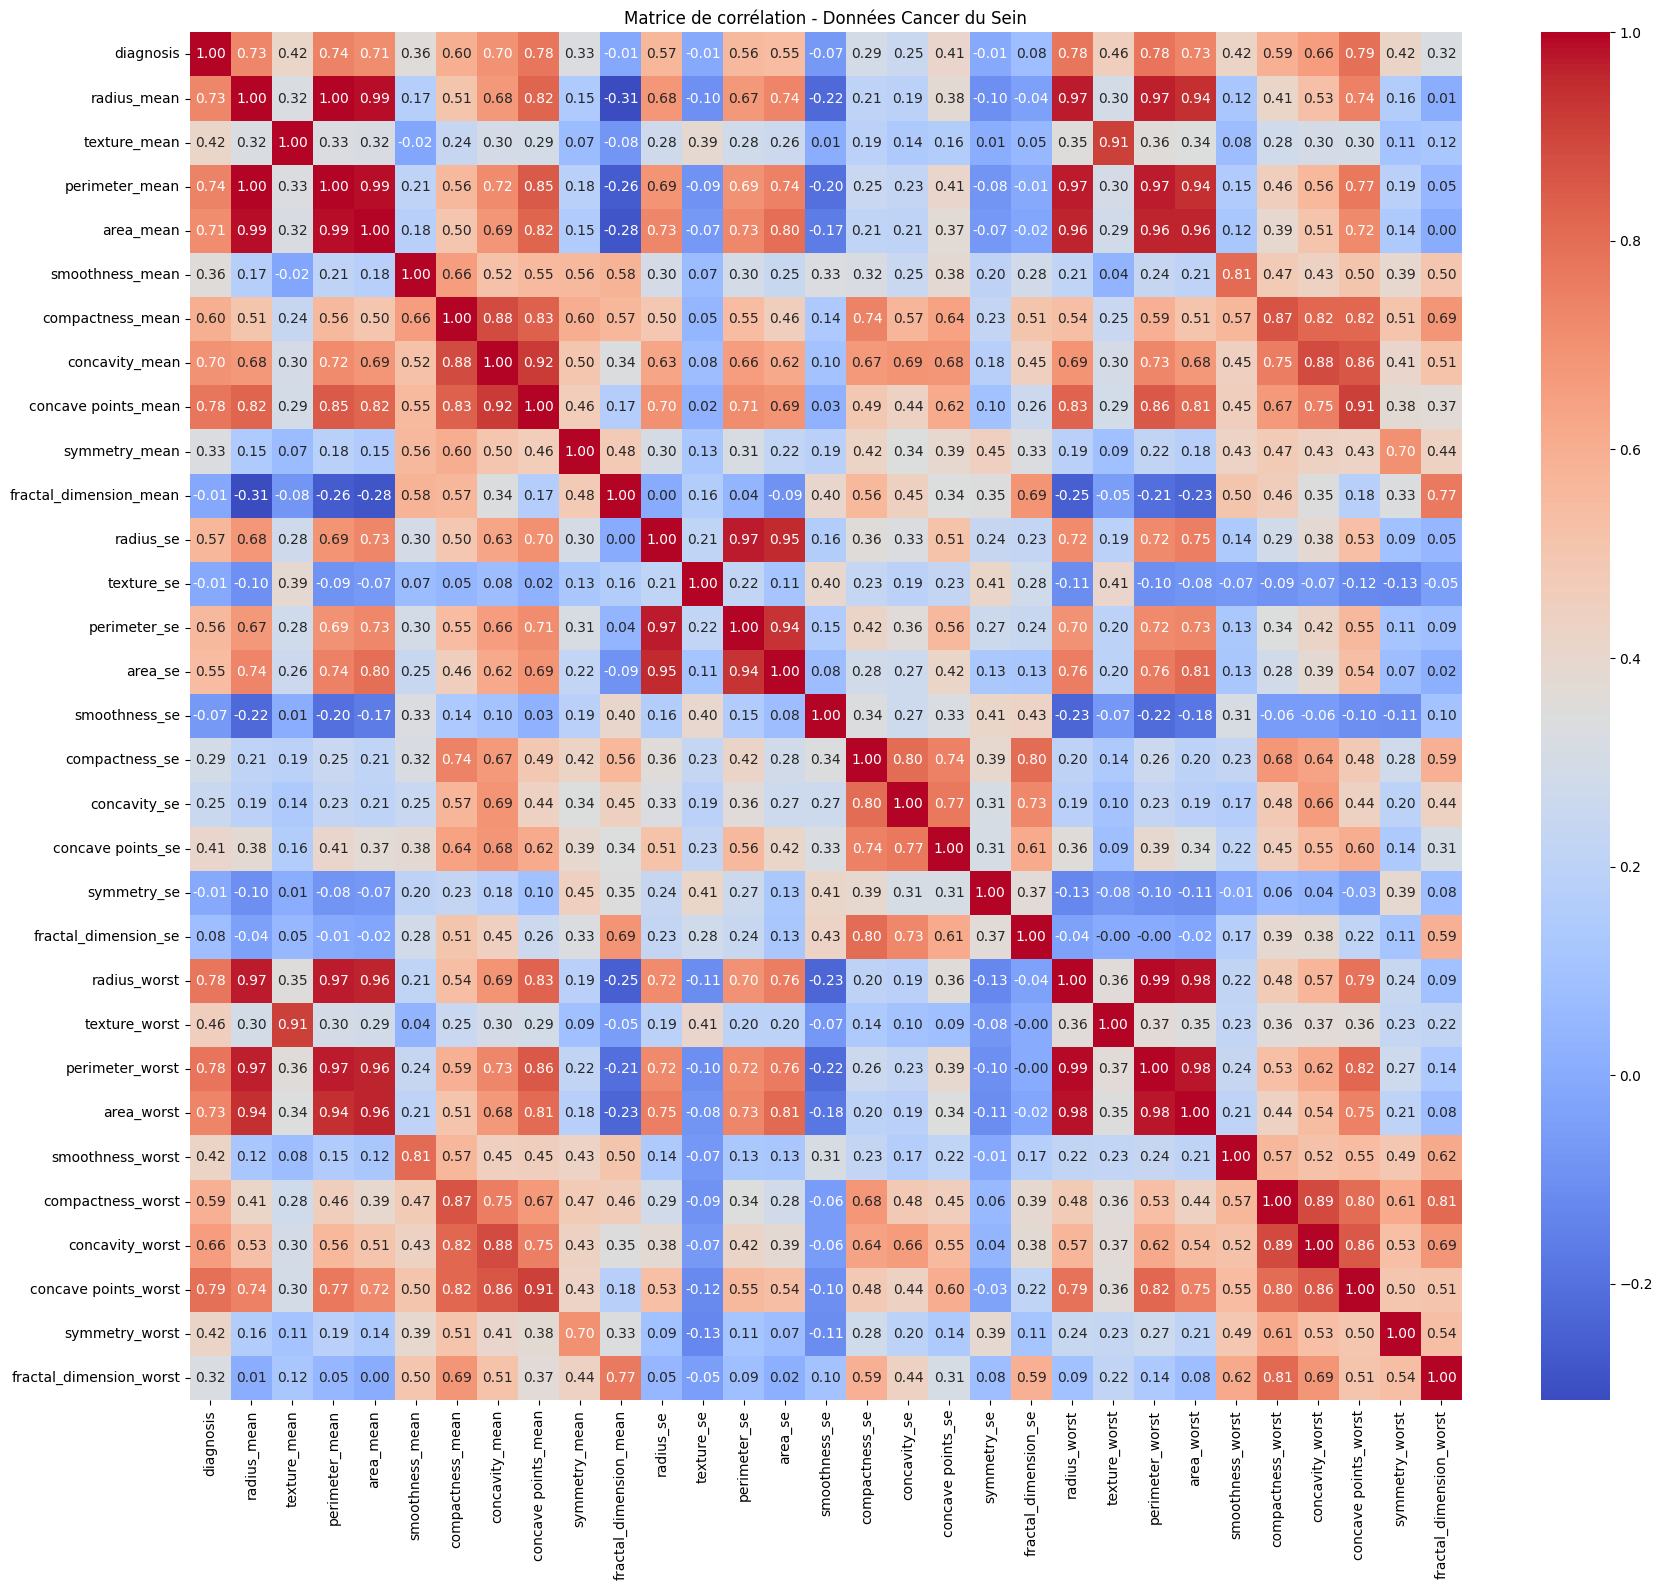

In [9]:
correlation_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(18, 16))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice de corrélation - Données Cancer du Sein")
plt.tight_layout()
plt.show()

In [10]:
#D'apres le graph .On commence large pour ne rien rater, et plus tard on pourra alléger le modèle si besoin.

#Phase:Choix du modèle et entraînement
# (On prépare les données, on apprend au modèle, puis on le teste pour voir s’il devine bien.)

X = df.drop(columns=['diagnosis'])  # X = tout ce qui décrit la tumeur (taille, forme, etc.)
y = df['diagnosis']                 # y = la réponse (bénin ou malin)


In [11]:
#On met tout sur la même échelle. Comme ça, aucune colonne n’écrase les autres.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
#On partage les données
#80% → pour apprendre ,20% → pour tester
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


In [ ]:
# On crée notre modèle,c’est la “machine” qui va deviner bénin/malin
logreg = LogisticRegression(max_iter=10000)


In [ ]:
#On apprend au modèle à faire la différence entre bénin et malin
logreg.fit(X_train, y_train)


In [ ]:
#On demande au modèle de faire des prédictions sur les cas qu’il n’a jamais vus (les 20% test)
y_pred = logreg.predict(X_test)


In [ ]:
#On regarde combien de bonnes réponses il a faites.
#accuracy = pourcentage de réussite
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy de la régression logistique : {accuracy:.2f}")


In [ ]:
#Phase: Évaluation approfondie
"""
confusion_matrix → un tableau qui montre combien de bénins et de malins le modèle a bien classés ou ratés

classification_report → précision, rappel, F1-score
précision = parmi ceux que le modèle dit “malin”, combien sont vraiment malins
rappel = parmi les vrais malins, combien ont été détectés
F1-score = moyenne équilibrée entre précision et rappel
"""
# matrice de confusion
cm = confusion_matrix(y_test, y_pred)
print("\nMatrice de confusion :")
print(cm)

# classification report
print("\nRapport détaillé :")
print(classification_report(y_test, y_pred, target_names=["Bénin","Malin"]))


In [ ]:
#Le resultat
"""
Le modèle marche très bien, surtout pour dire qu’une tumeur est bénigne.
Il est aussi très bon pour détecter les malins, mais il en rate encore 5% —
donc on pourrait encore l’améliorer pour éviter de manquer ces cas graves.
"""


In [ ]:
#Phase: Optimisation
"""
L’optimisation, c’est comme régler la sensibilité d’un détecteur.
La validation croisée vérifie qu’il n’est pas trompé par un échantillon chanceux,
et la recherche d’hyperparamètres lui donne le meilleur réglage
"""
# validation croisée sur 5 morceaux
scores = cross_val_score(logreg, X_scaled, y, cv=5)

print(f"Scores validation croisée : {scores}")
print(f"Score moyen : {scores.mean():.2f}")


param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(
    LogisticRegression(max_iter=10000),
    param_grid,
    cv=5
)
grid.fit(X_scaled, y)

print(f"Meilleur C : {grid.best_params_}")
print(f"Meilleur score : {grid.best_score_:.2f}")


In [ ]:
#Resultat
"""
La validation croisée confirme que notre modèle est robuste,
et la recherche d’hyperparamètres montre que la configuration de base était déjà bonne.
Avec 98% de score moyen, c’est un excellent résultat.
"""